## 基于ARIMA模型预测租车业务收入

### 目录
- 简介
- 数据处理
- 寻找模型参数
- 模型检验
- 预测

### 简介

        随着公司业务的发展，车队规模随之增加，加车计划不能沿袭以前仅凭数月业绩确定的简单逻辑。需要从历史数据中挖掘收入的周期和趋势因素，从而对未来的业绩做出合理预测，让加车计划有的放矢。根据历史收入数据预测未来收入属于时间序列问题，可以利用ARIMA模型进行预测。ARIMA模型包括AR（自回归项）、I（差分项）、MA（移动平均项），建模步骤主要包括数据处理（空值处理，索引替换为时间戳等）、确定差分项（d值）、自回归项（p）、移动平均项（q），模型检验及预测等步骤。

### 1、数据处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
df=pd.read_csv(r'D:\jupyter_file\revenue_forecast\date_incoming.csv',encoding="UTF-8",parse_dates=["date"],index_col=0)

In [3]:
#查看数据
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2019-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   revenue  731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


#### 数据无空值。

### 2、寻找模型参数

#### 2.1 确定d值

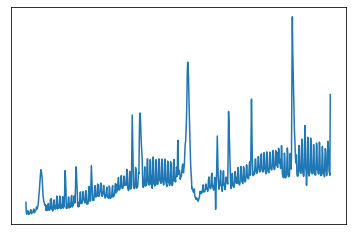

In [4]:
#观察数据趋势
plt.plot(df)
plt.xticks([]) 
plt.yticks([])
plt.rcParams['figure.figsize'] = (10, 6)

#### 数据中异常升高的部分为节日，可以看出数据大致以一周为周期变化，长期有向上的趋势。此外，数据也不是平稳的。

In [5]:
#进行一阶差分，用ADF检验判断一阶差分是否平稳
diff1=df.diff(1)
diff1.dropna(inplace=True)
adfuller(diff1)

(-9.237808165153679,
 1.6126692436031198e-15,
 18,
 711,
 {'1%': -3.439580754053961,
  '5%': -2.865613606467485,
  '10%': -2.568939269723711},
 21113.651263454918)

#### p值远小于0.05，拒绝零假设（零假设为序列不平稳），序列平稳，d=1。

### 2.2 确定p、q值

#### （1）ACF、PACF图

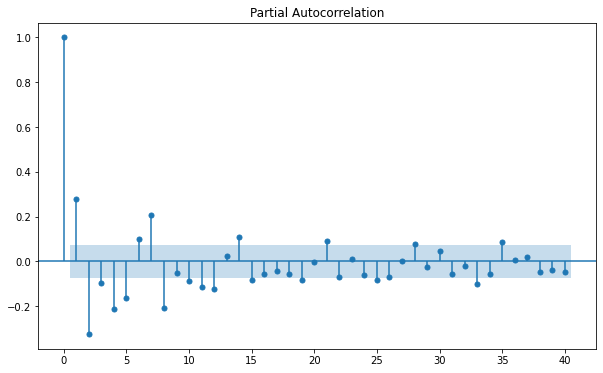

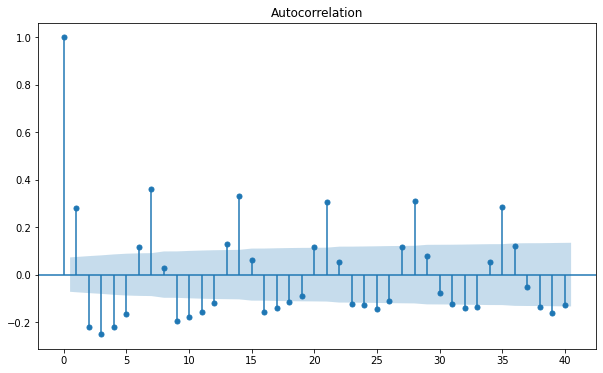

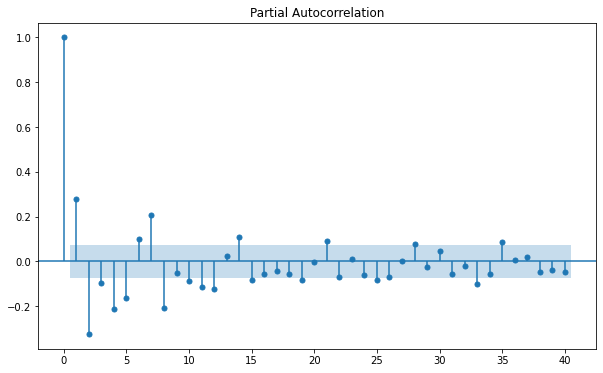

In [6]:
plot_acf(diff1,lags=40)
plot_pacf(diff1,lags=40)

#### PACF图大致在8阶后截尾，ACF图拖尾，需要用其它方法确定p，q值。

#### （2）信息准则定阶

In [7]:
import statsmodels.tsa.stattools as st
AIC=st.arma_order_select_ic(diff1,max_ar=10,max_ma=10,ic='aic')['aic_min_order']
AIC

(9, 7)

In [8]:
BIC=st.arma_order_select_ic(diff1,max_ar=10,max_ma=10,ic='bic')['bic_min_order']
BIC

(9, 7)

In [9]:
HQIC=st.arma_order_select_ic(diff1,max_ar=10,max_ma=10,ic='hqic')['hqic_min_order']
HQIC

(9, 7)

#### 不同信息准则得出的p，q一致，如果不一致则根据需要选择不同信息准则确定的参数。一般而言，AIC是从预测角度，选择一个好的模型用来预测，BIC是从拟合角度，选择一个对现有数据拟合最好的模型

#### （3）热力图

In [10]:
p_min = 0
q_min = 0
p_max = 10
q_max = 10

Text(0.5, 1.0, 'BIC')

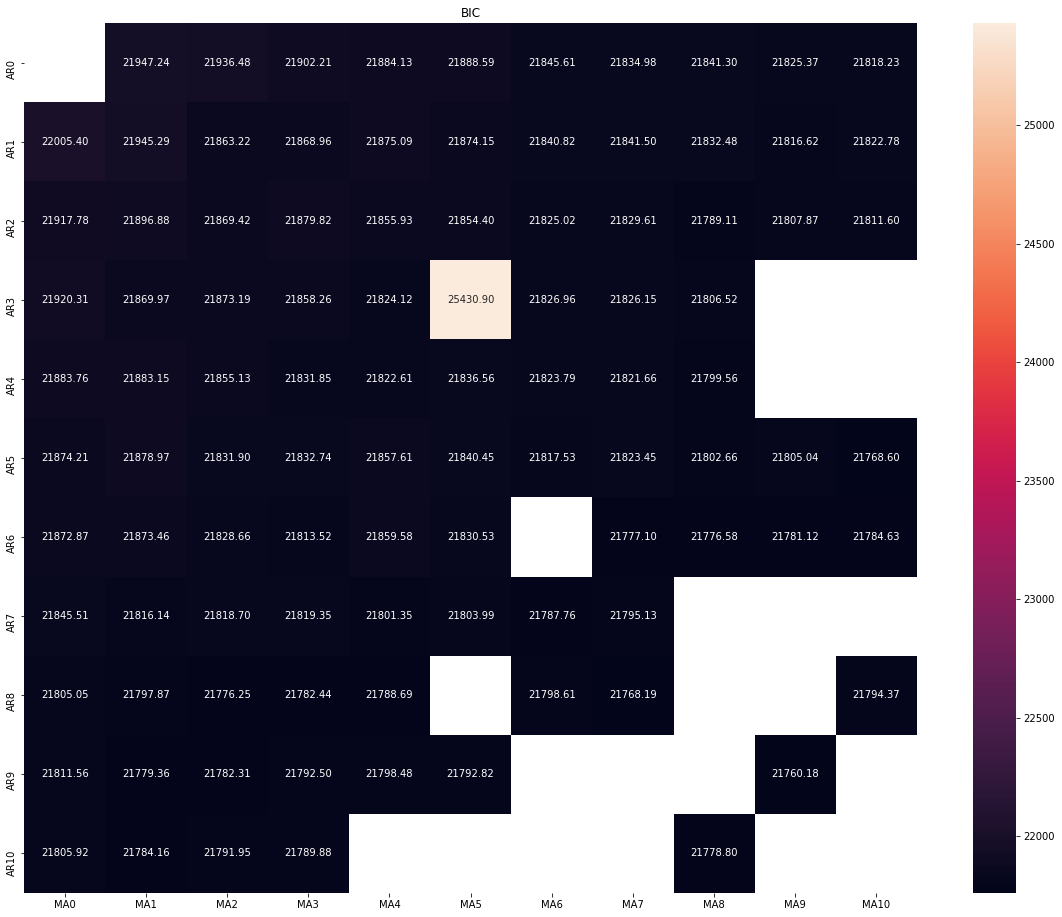

In [11]:
results_bic = pd.DataFrame(index=["AR{}".format(i) for i in range(p_min,p_max+1)],
                           columns=["MA{}".format(i) for i in range(q_min,q_max+1)])

import statsmodels.api as sm

import itertools
import seaborn as sns

for p,q in itertools.product(range(p_min,p_max+1),range(q_min,q_max+1)):
    if p==0 and q==0:
        results_bic.loc["AR{}".format(p),"MA{}".format(q)]=np.nan
        continue
    try:
        model=sm.tsa.ARMA(diff1,order=(p,q))
        results=model.fit()
        results_bic.loc["AR{}".format(p),"MA{}".format(q)]=results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

fig, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(results_bic,ax=ax,annot=True,fmt=".2f")
ax.set_title("BIC")

#### 根据热力图，BIC最小的p，q值为9，9，这与上述p，q值有差异。可将两种组合均用于模型进行预测，得出最佳结果。

### 3、模型检验

#### 3.1 模型残差正态性检验

In [12]:
#选取p、q分别为9、9
arma_model=sm.tsa.ARMA(diff1,order=(9,9))
result=arma_model.fit()
arma_model_resid=result.resid

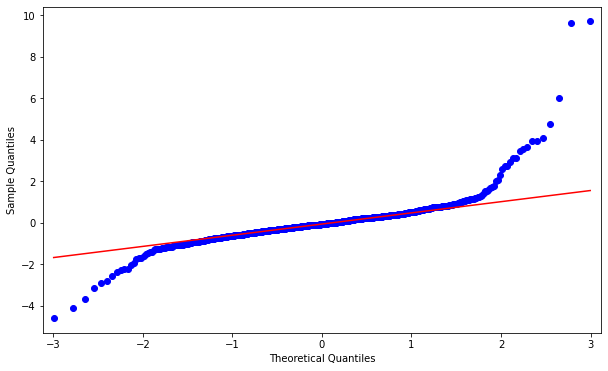

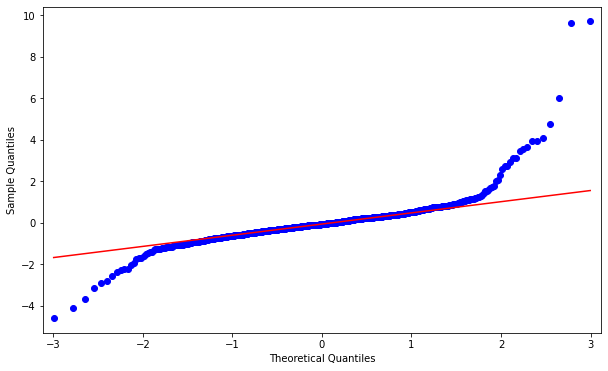

In [13]:
from statsmodels.graphics.api import qqplot
qqplot(arma_model_resid,line='q',fit=True)

#### qq图上大部分点很好的满足正态分布，但有一些点离直线较远，这些点应该是节日收入异常升高的点。

#### 3.2 残差自相关性检验

In [14]:
durbin_watson(arma_model_resid.values)

1.8647014073000145

#### D-W值1.85，接近2，认为残差无自相关性。

#### 3.3 Ljung-Box检验

In [15]:
r,q_,p_ = sm.tsa.acf(arma_model_resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q_, p_]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.000367   0.000099  0.992065
2.0  -0.010477   0.080670  0.960468
3.0  -0.002163   0.084108  0.993674
4.0   0.003842   0.094974  0.998908
5.0  -0.010453   0.175510  0.999355
6.0   0.002293   0.179392  0.999888
7.0   0.092642   6.522626  0.480213
8.0  -0.056169   8.857671  0.354445
9.0  -0.030491   9.546695  0.388412
10.0 -0.012155   9.656338  0.471143
11.0  0.008836   9.714368  0.556248
12.0 -0.032024  10.477596  0.574137
13.0  0.022844  10.866516  0.621999
14.0 -0.006409  10.897174  0.694094
15.0 -0.008969  10.957287  0.755616
16.0 -0.034102  11.827636  0.755757
17.0  0.004271  11.841304  0.809650
18.0  0.034695  12.744724  0.806510
19.0 -0.012826  12.868364  0.845241
20.0  0.007060  12.905880  0.881386
21.0 -0.023544  13.323662  0.896865
22.0 -0.030541  14.027671  0.900494
23.0  0.006645  14.061042  0.925110
24.0  0.004519  14.076502  0.944904
25.0 -0.003560  14.086106  0.960211
26.0 -0.030642  14.798786  0

#### 一直到40阶，p_value都是大于0.05，即序列为白噪声序列。

### 4、预测

In [16]:
prediction=result.predict("2021-01-01","2021-03-31",dynamic=True) #预测2021-01-01到2021-03-31的收入
s_0=pd.Series(df["revenue"])
s_1=pd.Series([s_0[730]],index=[s_0.index[730]]).append(prediction) #预测数据还原需要前一日（即2020-12-31日）的实际值
s_restored=s_1.cumsum()

In [17]:
df_1=pd.read_csv(r"D:\jupyter_file\revenue_forecast\20210101-20210331收入.csv",encoding="gbk",parse_dates=["date"],index_col=0)

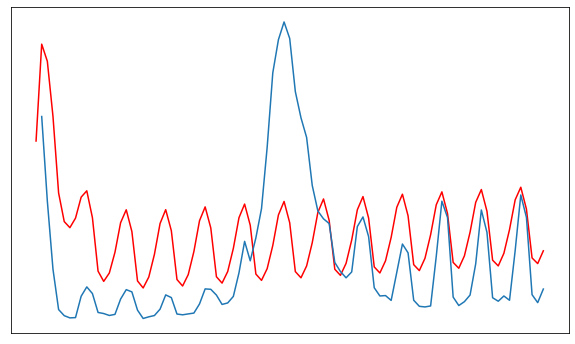

In [18]:
plt.plot(s_restored,color="r")
plt.xticks([]) 
plt.yticks([])
plt.plot(df_1)

#### 剔除春节的影响，模型基本预测了2021年Q1每日的收入。目前看来，模型存在最大的问题是无法预测节日的收入，下一步将对此进行探索。

In [20]:
s_re_1.to_csv("1-6月预测",encoding="utf-8")